In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
import tqdm
import heapq
import datetime
import glob
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
BASE_PATH = 'data/UCF-101'
VIDEOS_PATH = os.path.join(BASE_PATH, '**','*.avi')
FILE_SELECTOR = "**/*.avi"
SEQUENCE_LENGTH = 40

# Step 1 - Visualize Data

### Plot distribution

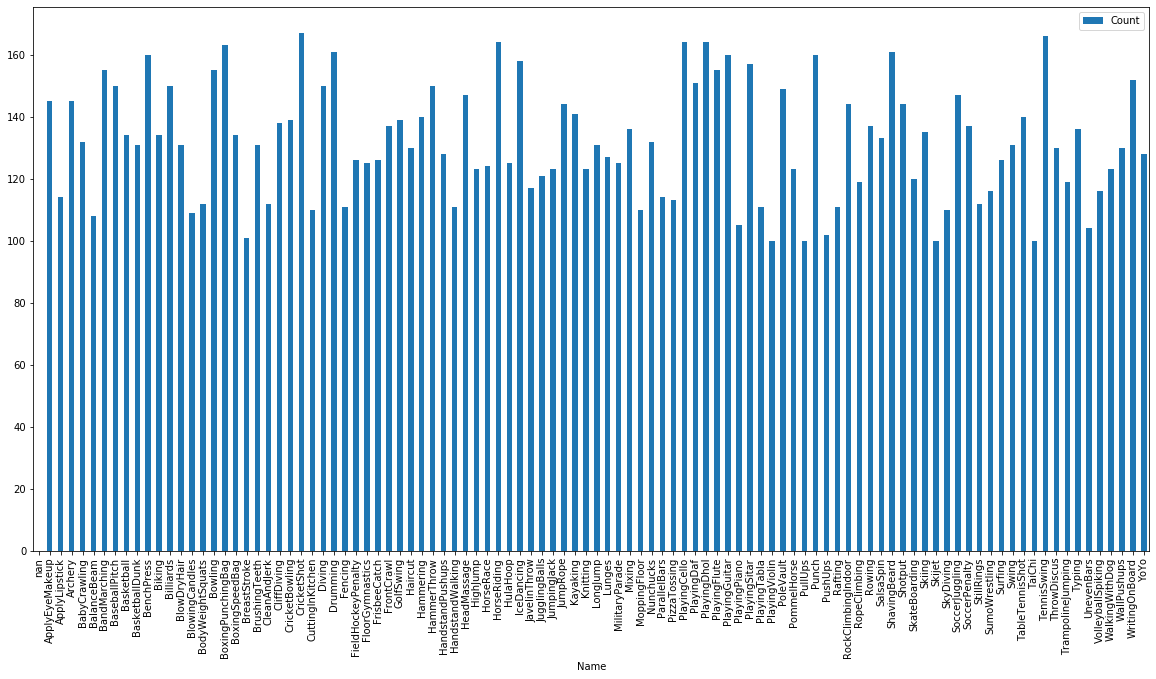

In [3]:
files = [f for f in glob.glob(BASE_PATH + '/' + FILE_SELECTOR, recursive=True)]
df = pd.DataFrame(columns=['Name', 'Count'], index=['Name'])
for f in files:
    directory = os.path.dirname(f).split(os.sep)[1]    
    index = df.index[df['Name'] == directory].tolist()
    if len(index) == 0:        
        df = df.append({'Name': directory, 'Count': 0}, ignore_index=True)

    df.loc[df['Name'] == directory, 'Count'] = df.loc[df['Name'] == directory, 'Count'] + 1

df.plot.bar(x='Name', y='Count', rot=90, figsize=(20,10))

# Step 2 - Prepare Data

### Train/Validation split

In [7]:
def read_classes(directory, selector='**/*.avi'):
    files = [f for f in glob.glob(directory + '/'+ selector, recursive=True)]
    df = pd.DataFrame(columns=['classes', 'classids', 'filepaths'])
    
    # Append all files
    for f in files:
        classname = os.path.dirname(f).split(os.sep)[1]    
        filepath = f.replace('\\', '/').replace(BASE_PATH, '')[1:]
        df = df.append({'classes': classname, 'classids': '', 'filepaths': filepath}, ignore_index=True)

    # Add class ids
    classes = df.classes.unique()
    for idx in range(len(classes)):
        classname = classes[idx]
        df.loc[(df['classes'] == classname),'classids'] = idx + 1   
    
    return df
    
df_classes = read_classes(BASE_PATH)

In [8]:
classes = df_classes.classes.unique()
print('Classes: {}'.format(len(classes)))
print(classes)

Classes: 101
['ApplyEyeMakeup' 'ApplyLipstick' 'Archery' 'BabyCrawling' 'BalanceBeam'
 'BandMarching' 'BaseballPitch' 'Basketball' 'BasketballDunk' 'BenchPress'
 'Biking' 'Billiards' 'BlowDryHair' 'BlowingCandles' 'BodyWeightSquats'
 'Bowling' 'BoxingPunchingBag' 'BoxingSpeedBag' 'BreastStroke'
 'BrushingTeeth' 'CleanAndJerk' 'CliffDiving' 'CricketBowling'
 'CricketShot' 'CuttingInKitchen' 'Diving' 'Drumming' 'Fencing'
 'FieldHockeyPenalty' 'FloorGymnastics' 'FrisbeeCatch' 'FrontCrawl'
 'GolfSwing' 'Haircut' 'Hammering' 'HammerThrow' 'HandstandPushups'
 'HandstandWalking' 'HeadMassage' 'HighJump' 'HorseRace' 'HorseRiding'
 'HulaHoop' 'IceDancing' 'JavelinThrow' 'JugglingBalls' 'JumpingJack'
 'JumpRope' 'Kayaking' 'Knitting' 'LongJump' 'Lunges' 'MilitaryParade'
 'Mixing' 'MoppingFloor' 'Nunchucks' 'ParallelBars' 'PizzaTossing'
 'PlayingCello' 'PlayingDaf' 'PlayingDhol' 'PlayingFlute' 'PlayingGuitar'
 'PlayingPiano' 'PlayingSitar' 'PlayingTabla' 'PlayingViolin' 'PoleVault'
 'PommelHorse'

In [9]:
trainfile = open('data/train.txt', 'w')
testfile = open('data/test.txt', 'w')

for idx in range(len(classes)):    
    class_subset = df_classes[df_classes['classes'] == classes[idx]]
    train, test = train_test_split(class_subset, test_size=0.2)    
    
    for index, row in train.iterrows():
        trainfile.write(row['filepaths'] + ' ' + str(row['classids']) + '\n')
        
    for index, row in test.iterrows():
        testfile.write(row['filepaths'] + '\n')        
    
trainfile.close()
testfile.close()

# Step 3 - Extract features from videos and cache them in files

### Sample 'SEQUENCE_LENGTH' frames from each video

In [10]:
def frame_generator():
    video_paths = tf.io.gfile.glob(VIDEOS_PATH)
    np.random.shuffle(video_paths)
    for video_path in video_paths:
        frames = []
        cap = cv2.VideoCapture(video_path)
        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample_every_frame = max(1, num_frames // SEQUENCE_LENGTH)
        current_frame = 0

        label = os.path.basename(os.path.dirname(video_path))

        max_images = SEQUENCE_LENGTH
        while True:
            success, frame = cap.read()
            if not success:
                break

            if current_frame % sample_every_frame == 0:
                # OPENCV reads in BGR, tensorflow expects RGB so we invert the order
                frame = frame[:, :, ::-1]
                img = tf.image.resize(frame, (299, 299))
                img = tf.keras.applications.inception_v3.preprocess_input(
                    img)
                max_images -= 1
                yield img, video_path

            if max_images == 0:
                break
            current_frame += 1

dataset = tf.data.Dataset.from_generator(frame_generator,
             output_types=(tf.float32, tf.string),
             output_shapes=((299, 299, 3), ()))

dataset = dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

#### Extract Features from videos

In [11]:
inception_v3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
x = inception_v3.output

# We add Average Pooling to transform the feature map from
# 8 * 8 * 2048 to 1 x 2048, as we don't need spatial information
pooling_output = tf.keras.layers.GlobalAveragePooling2D()(x)
feature_extraction_model = tf.keras.Model(inception_v3.input, pooling_output)

### Extract features and store them in .npy files¶
#### Extraction takes about ~1h20 minutes on an NVIDIA 1080 GPU

In [ ]:
current_path = None
all_features = []

for img, batch_paths in tqdm.tqdm(dataset):
    batch_features = feature_extraction_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1))
    
    for features, path in zip(batch_features.numpy(), batch_paths.numpy()):
        if path != current_path and current_path is not None:
            output_path = current_path.decode().replace('.avi', '.npy')
            np.save(output_path, all_features)
            all_features = []
            
        current_path = path
        all_features.append(features)

# Step 2: Train the LSTM on video features

#### Labels preprocessing

In [12]:
LABELS = classes
encoder = LabelBinarizer()
encoder.fit(LABELS)
print('Classes: {}'.format(len(encoder.classes_)))

Classes: 101


#### Defining the model

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0.),
    tf.keras.layers.LSTM(512, dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [15]:
test_file = os.path.join('data', 'test.txt')
train_file = os.path.join('data', 'train.txt')

with open('data/test.txt') as f:
    test_list = [row.strip() for row in list(f)]

with open('data/train.txt') as f:
    train_list = [row.strip() for row in list(f)]
    train_list = [row.split(' ')[0] for row in train_list]

def make_generator(file_list):
    def generator():
        np.random.shuffle(file_list)
        for path in file_list:
            full_path = os.path.join(BASE_PATH, path).replace('.avi', '.npy')

            label = os.path.basename(os.path.dirname(path))
            features = np.load(full_path)

            padded_sequence = np.zeros((SEQUENCE_LENGTH, 2048))
            padded_sequence[0:len(features)] = np.array(features)

            transformed_label = encoder.transform([label])
            yield padded_sequence, transformed_label[0]
    return generator

In [16]:
train_dataset = tf.data.Dataset.from_generator(make_generator(train_list),
                 output_types=(tf.float32, tf.int16),
                 output_shapes=((SEQUENCE_LENGTH, 2048), (len(LABELS))))
train_dataset = train_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)


valid_dataset = tf.data.Dataset.from_generator(make_generator(test_list),
                 output_types=(tf.float32, tf.int16),
                 output_shapes=((SEQUENCE_LENGTH, 2048), (len(LABELS))))
valid_dataset = valid_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

In [17]:
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, update_freq=1000, profile_batch=0)
checkpoint = ModelCheckpoint("model.h5", verbose=1, save_best_only=True)
earlystopping = EarlyStopping(patience=10, verbose=1)
model.fit(train_dataset, epochs=100, callbacks=[tensorboard_callback, checkpoint, earlystopping], validation_data=valid_dataset)

Epoch 1/100
    664/Unknown - 405s 610ms/step - loss: 3.5638 - accuracy: 0.1760 - top_k_categorical_accuracy: 0.3771
Epoch 00001: val_loss improved from inf to 2.07665, saving model to model.h5
664/664 [==============================] - 511s 769ms/step - loss: 3.5638 - accuracy: 0.1760 - top_k_categorical_accuracy: 0.3771 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 2/100
168/169 [============================>.] - ETA: 0s - loss: 2.3247 - accuracy: 0.3780 - top_k_categorical_accuracy: 0.6946
Epoch 00002: val_loss improved from 2.07665 to 1.41283, saving model to model.h5
664/664 [==============================] - 505s 760ms/step - loss: 2.1381 - accuracy: 0.4350 - top_k_categorical_accuracy: 0.7443 - val_loss: 1.4128 - val_accuracy: 0.5898 - val_top_k_categorical_accuracy: 0.8734
Epoch 3/100
168/169 [============================>.] - ETA: 0s - loss: 1.6553 - accuracy: 0.5420 - top_k_categorical_accuracy: 0.8218
Epoch 00003: val_lo

Epoch 21/100
168/169 [============================>.] - ETA: 0s - loss: 0.6468 - accuracy: 0.8356 - top_k_categorical_accuracy: 0.9643
Epoch 00021: val_loss did not improve from 0.53734
664/664 [==============================] - 501s 754ms/step - loss: 0.6816 - accuracy: 0.8231 - top_k_categorical_accuracy: 0.9643 - val_loss: 0.5716 - val_accuracy: 0.8467 - val_top_k_categorical_accuracy: 0.9715
Epoch 22/100
168/169 [============================>.] - ETA: 0s - loss: 0.7242 - accuracy: 0.8136 - top_k_categorical_accuracy: 0.9628
Epoch 00022: val_loss did not improve from 0.53734
664/664 [==============================] - 601s 905ms/step - loss: 0.7212 - accuracy: 0.8188 - top_k_categorical_accuracy: 0.9616 - val_loss: 0.5837 - val_accuracy: 0.8530 - val_top_k_categorical_accuracy: 0.9722
Epoch 23/100
168/169 [============================>.] - ETA: 0s - loss: 0.6834 - accuracy: 0.8296 - top_k_categorical_accuracy: 0.9635
Epoch 00023: val_loss improved from 0.53734 to 0.50638, saving mode

# Step 3: Predict on Video

In [18]:
def load_features(path):
    features = np.load(path)
    padded_sequence = np.zeros((SEQUENCE_LENGTH, 2048))
    padded_sequence[0:len(features)] = np.array(features)
    return np.array([padded_sequence])

features = load_features('data/UCF-101/SumoWrestling/v_SumoWrestling_g06_c04.npy')
prediction = model.predict(features)

In [19]:
k = 5
idxs = heapq.nlargest(k, range(len(prediction[0])), prediction[0].__getitem__)
for i in idxs:
    label = encoder.classes_[i]
    pct = prediction[0][i]
    print(label+ ' ' + "{0:.0%}".format(pct))

SumoWrestling 100%
BasketballDunk 0%
BalanceBeam 0%
FrontCrawl 0%
FloorGymnastics 0%
